# Example: Using MIRAGE to Generate Wide Field Slitless Exposures

The `mirage` simulator is broken up into four basic stages:

1. **Creation of a "seed image".**<br>
   This is generally a noiseless countrate image that contains signal
   only from the astronomical sources to be simulated. Currently, the 
   nircam_simulator package contains code to produce a seed image starting
   from object catalogs.<br><br>
   
2. **Dispersion of the seed image.**<br>
   Use the disperser code to turn the imaging seed image into a seed 
   image containing the dispersed spectra of all sources.<br><br>
   
3. **Dark current prep.**<br>
   The simualted data will be created by adding the simulated sources
   in the seed image to a real NIRCam dark current exposure. This step
   converts the dark current exposure to the requested readout pattern
   and subarray size requested by the user.<br><br>
   
4. **Observation generation.**<br>
   This step converts the seed image into an exposure of the requested
   readout pattern and subarray size. It also adds cosmic rays and 
   Poisson noise, as well as other detector effects (IPC, crosstalk, etc).
   This exposure is then added to the dark current exposure from step 2.

*Table of Contents:*
* Single image simulation
    * [Running simulator steps independently](#run_steps_independently)
    * [Running simulator steps together](#run_steps_together)
* [Running multiple simulations](#mult_sims)
* [Generating `yaml` files](#make_yaml)
* [Example `yaml` file](#yaml_example)

---
## Getting Started

<div class="alert alert-block alert-warning">
**Important:** 
Before proceeding, ensure you have set the MIRAGE_DATA environment variable to point to the directory that contains the reference files associated with MIRAGE.
</div>

<div class="alert alert-block alert-info">
**Dependencies:**<br><br>

1) Install GRISMCONF from https://github.com/npirzkal/GRISMCONF<br><br>
2) Install GRISM_NIRCAM (NIRCAM configuration files) from https://github.com/npirzkal/GRISM_NIRCAM (Though this dependency should eventually go away once GRISM_NIRCAM is packaged with the other simulator input files in the NIRCAM_SIM_DATA environment variable)
</div>

In [1]:
# Set the MIRAGE_DATA environment variable if it is not
# set already.
import os
#os.environ['MIRAGE_DATA'] = '/myfiles/mirage_data'

In [2]:
# For examining outputs
from glob import glob
from scipy.stats import sigmaclip
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from NIRCAM_Gsim.grism_seed_disperser import Grism_seed
%matplotlib inline

In [3]:
# Import the three steps of the simulator. 
from mirage.seed_image import catalog_seed_image
from mirage.dark import dark_prep
from mirage.ramp_generator import obs_generator
from mirage.yaml import yaml_update

In [4]:
# yaml files that contains the parameters of the
# data to be simulated
# Example yaml file shown at the bottom of this
# notebook
yamlfile1 = 'wfss_example_data/wfss_f250m_test.yaml'
yamlfile2 = 'wfss_example_data/wfss_f300m_test.yaml'
yamlfile3 = 'wfss_example_data/wfss_f410m_test.yaml'
yamlfile4 = 'wfss_example_data/wfss_f460m_test.yaml'

---
<a id='run_steps_independently'></a>
# Running simulation steps independently

## First generate the "seed images" 
Each is generally a 2D noiseless countrate image that contains only 
simulated astronomical sources

In order for the disperser software to function, we need seed images
through several filters. The disperser will use the relative brightnesses
of objects in the filters to determine the shape of the continuum for each.

In [5]:
seed1 = catalog_seed_image.Catalog_seed()
seed1.paramfile = yamlfile1
seed1.make_seed()

seed2 = catalog_seed_image.Catalog_seed()
seed2.paramfile = yamlfile2
seed2.make_seed()

seed3 = catalog_seed_image.Catalog_seed()
seed3.paramfile = yamlfile3
seed3.make_seed()

seed4 = catalog_seed_image.Catalog_seed()
seed4.paramfile = yamlfile4
seed4.make_seed()

'config' specified: Using /Users/lchambers/TEL/mirage/mirage/config/NIRCam_subarray_definitions.list for Reffiles:subarray_defs input file
'config' specified: Using /Users/lchambers/TEL/mirage/mirage/config/xtalk20150303g0.errorcut.txt for Reffiles:crosstalk input file
'config' specified: Using /Users/lchambers/TEL/mirage/mirage/config/NIRCam_zeropoints.list for Reffiles:flux_cal input file
'config' specified: Using /Users/lchambers/TEL/mirage/mirage/config/nircam_read_pattern_definitions.list for Reffiles:readpattdefs input file
'config' specified: Using /Users/lchambers/TEL/mirage/mirage/config/placeholder.txt for Reffiles:filter_throughput input file
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
Frametime is 10.736770000000002
Creating signal rate image of synthetic inputs.
Point list input positions assumed to be in units of RA and Dec.
No point source catalog index numbers. Adding to output: /Users/lchambers/TEL/mirage/examples/wfss_example_data/V424

### Look at the seed image

In [6]:
def show(array,title,min=0,max=1000):
    plt.figure(figsize=(12,12))
    plt.imshow(array,clim=(min,max))
    plt.title(title)
    plt.colorbar().set_label('DN/s')

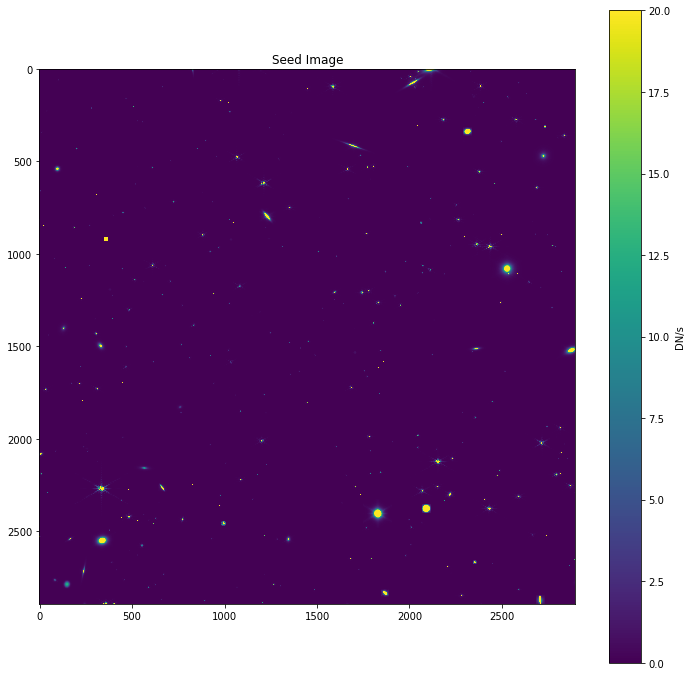

In [7]:
show(seed1.seedimage,'Seed Image',max=20)

## Disperse the seed image

In [9]:
# Specify the desired direction (row, column) of the dispersed sources
# as well as the crossing filter to use
crossing_filter = 'F444W'
module = 'A'    # 'A' or 'B'
direction = 'R' # 'R' for row or 'C' for column
image_seeds = [seed1.seed_file, seed2.seed_file, seed3.seed_file, seed4.seed_file]
dmode = 'mod{}_{}'.format(module.upper(), direction.upper())
loc = os.path.expandvars("$MIRAGE_DATA/nircam/GRISM_NIRCAM/")
background_file = "{}_{}_back.fits".format(crossing_filter,dmode) # Located within 'loc' above
t = Grism_seed(image_seeds, crossing_filter, dmode, config_path=loc)
t.observation()
t.finalize(Back=background_file)

146459 pixels to process
dir image: /Users/lchambers/TEL/mirage/examples/wfss_example_data/V42424024002P000000000112o_B5_F250M_seed_uncal_F250M_seed_image.fits
Loaded /Users/lchambers/TEL/mirage/examples/wfss_example_data/V42424024002P000000000112o_B5_F250M_seed_uncal_F250M_seed_image.fits wavelength: 2.503 A
dir image: /Users/lchambers/TEL/mirage/examples/wfss_example_data/V42424024002P000000000112o_B5_F300M_seed_uncal_F300M_seed_image.fits
Loaded /Users/lchambers/TEL/mirage/examples/wfss_example_data/V42424024002P000000000112o_B5_F300M_seed_uncal_F300M_seed_image.fits wavelength: 2.9898 A
dir image: /Users/lchambers/TEL/mirage/examples/wfss_example_data/V42424024002P000000000112o_B5_F410M_seed_uncal_F410M_seed_image.fits
Loaded /Users/lchambers/TEL/mirage/examples/wfss_example_data/V42424024002P000000000112o_B5_F410M_seed_uncal_F410M_seed_image.fits wavelength: 4.0924 A
dir image: /Users/lchambers/TEL/mirage/examples/wfss_example_data/V42424024002P000000000112o_B5_F460M_seed_uncal_F4

8.328756093978882 s.
2 of 100
1465 pixels loaded for dispersion...
8.919694900512695 s.
3 of 100
1465 pixels loaded for dispersion...
8.42842411994934 s.
4 of 100
1465 pixels loaded for dispersion...
8.486541986465454 s.
5 of 100
1465 pixels loaded for dispersion...
8.67102599143982 s.
6 of 100
1465 pixels loaded for dispersion...
8.643741130828857 s.
7 of 100
1465 pixels loaded for dispersion...
8.935518980026245 s.
8 of 100
1465 pixels loaded for dispersion...
8.755717992782593 s.
9 of 100
1465 pixels loaded for dispersion...
9.554296970367432 s.
10 of 100
1465 pixels loaded for dispersion...
9.013683080673218 s.
11 of 100
1465 pixels loaded for dispersion...
10.041365146636963 s.
12 of 100
1465 pixels loaded for dispersion...
9.23117709159851 s.
13 of 100
1465 pixels loaded for dispersion...
8.723329067230225 s.
14 of 100
1465 pixels loaded for dispersion...
8.917458057403564 s.
15 of 100
1465 pixels loaded for dispersion...
8.731143951416016 s.
16 of 100
1465 pixels loaded for disp

### Look at the dispersed seed image

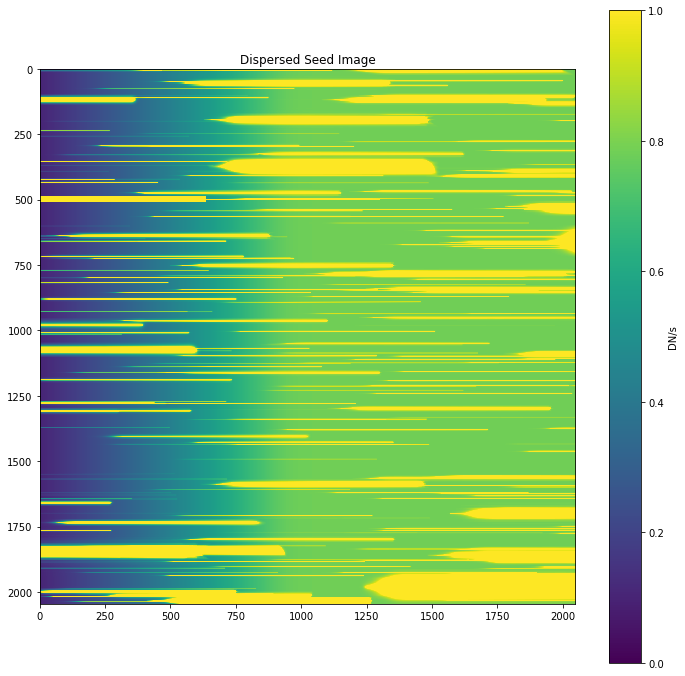

In [10]:
show(t.final,'Dispersed Seed Image',max=1)

## Prepare the dark current exposure
This will serve as the base of the simulated data.
This step will linearize the dark current (if it 
is not already), and reorganize it into the 
requested readout pattern and number of groups.

In [11]:
d = dark_prep.DarkPrep()
d.paramfile = yamlfile1
d.prepare()

'config' specified: Using /Users/lchambers/TEL/mirage/mirage/config/NIRCam_subarray_definitions.list for Reffiles:subarray_defs input file
'config' specified: Using /Users/lchambers/TEL/mirage/mirage/config/nircam_read_pattern_definitions.list for Reffiles:readpattdefs input file
'config' specified: Using /Users/lchambers/TEL/mirage/mirage/config/xtalk20150303g0.errorcut.txt for Reffiles:crosstalk input file
'config' specified: Using /Users/lchambers/TEL/mirage/mirage/config/dq_init.cfg for newRamp:dq_configfile input file
'config' specified: Using /Users/lchambers/TEL/mirage/mirage/config/saturation.cfg for newRamp:sat_configfile input file
'config' specified: Using /Users/lchambers/TEL/mirage/mirage/config/superbias.cfg for newRamp:superbias_configfile input file
'config' specified: Using /Users/lchambers/TEL/mirage/mirage/config/refpix.cfg for newRamp:refpix_configfile input file
'config' specified: Using /Users/lchambers/TEL/mirage/mirage/config/linearity.cfg for newRamp:linear_con

### Look at the dark current 
For this, we will look at an image of the final group
minus the first group

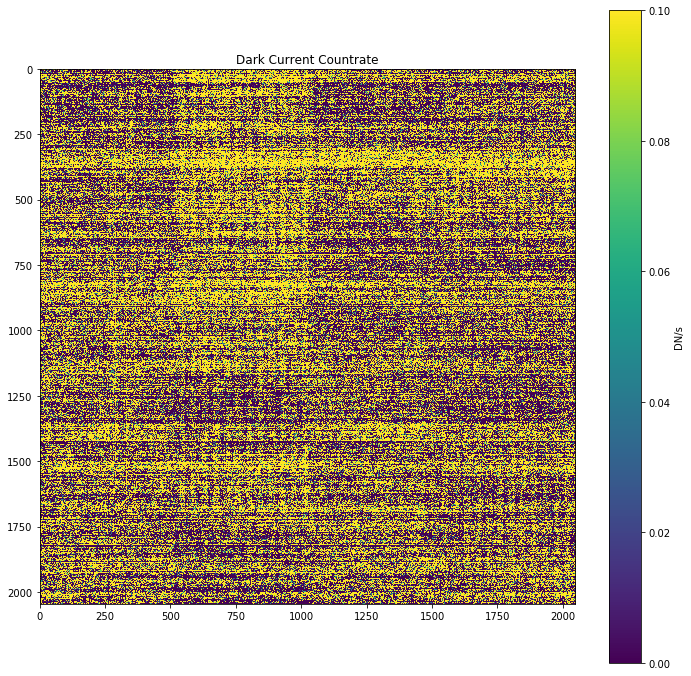

In [12]:
exptime = d.linDark.header['NGROUPS'] * seed1.frametime
diff = (d.linDark.data[0,-1,:,:] - d.linDark.data[0,0,:,:]) / exptime
show(diff,'Dark Current Countrate',max=0.1)

## Create the final exposure
Turn the seed image into a exposure of the 
proper readout pattern, and combine it with the
dark current exposure. Cosmic rays and other detector
effects are added. 

The output can be either this linearized exposure, or
a 'raw' exposure where the linearized exposure is 
"unlinearized" and the superbias and 
reference pixel signals are added, or the user can 
request both outputs. This is controlled from
within the yaml parameter file.

In this case, we need a new yaml file, since the yaml
files used eariler were used to generate the imaging mode
seed images. 

In [13]:
y = yaml_update.YamlUpdate()
y.file = yamlfile1
y.filter = crossing_filter
y.pupil = 'GRISM' + direction
y.outname = 'wfss_example_data/wfss_dispersed_{}_{}.yaml'.format(dmode,crossing_filter)
y.run()

In [14]:
obs = obs_generator.Observation()
obs.linDark = d.prepDark
obs.seed = t.final
obs.segmap = seed1.seed_segmap # not used in this step
obs.seedheader = seed1.seedinfo # not used in this step
obs.paramfile = y.outname
obs.create()


Running observation generator....

'config' specified: Using /Users/lchambers/TEL/mirage/mirage/config/NIRCam_subarray_definitions.list for Reffiles:subarray_defs input file
'config' specified: Using /Users/lchambers/TEL/mirage/mirage/config/nircam_read_pattern_definitions.list for Reffiles:readpattdefs input file
'config' specified: Using /Users/lchambers/TEL/mirage/mirage/config/xtalk20150303g0.errorcut.txt for Reffiles:crosstalk input file
'config' specified: Using /Users/lchambers/TEL/mirage/mirage/config/nircam_filter_pupil_pairings.list for Reffiles:filtpupilcombo input file
'config' specified: Using /Users/lchambers/TEL/mirage/mirage/config/NIRCam_zeropoints.list for Reffiles:flux_cal input file
Requested readout pattern RAPID is valid. Using nframe = 1 and nskip = 0
Frametime is 10.736770000000002
Base cosmic ray probability per pixel per second: 5.730773780196465e-06
Integration 0:
    Averaging frame 0 into group 0
    Averaging frame 1 into group 1
    Averaging frame 2 int

WCS info for /Users/lchambers/TEL/mirage/examples/wfss_example_data/V42424024002P000000000112o_B5_F250M_seed_linear_dispersed_GRISMR_crossing_F444W_linear.fits complete.


Final linearized exposure saved to:
/Users/lchambers/TEL/mirage/examples/wfss_example_data/V42424024002P000000000112o_B5_F250M_seed_linear_dispersed_GRISMR_crossing_F444W_linear.fits


WCS info for /Users/lchambers/TEL/mirage/examples/wfss_example_data/V42424024002P000000000112o_B5_F250M_seed_uncal_dispersed_GRISMR_crossing_F444W_uncal.fits complete.


Final raw exposure saved to
/Users/lchambers/TEL/mirage/examples/wfss_example_data/V42424024002P000000000112o_B5_F250M_seed_uncal_dispersed_GRISMR_crossing_F444W_uncal.fits
Observation generation complete.


### Examine the final output image
Again, we will look at the last group minus the first group, from the linear output integration

In [15]:
with fits.open(obs.linear_output) as h:
    lindata = h[1].data
    header = h[0].header

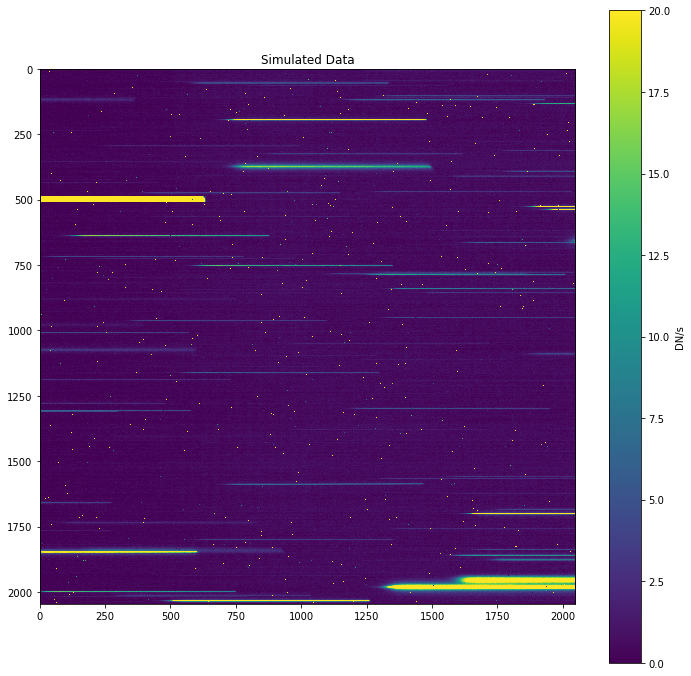

In [16]:
exptime = header['EFFINTTM']
diffdata = (lindata[0,-1,:,:] - lindata[0,0,:,:]) / exptime
show(diffdata,'Simulated Data',min=0,max=20)

/Users/lchambers/miniconda3/envs/OTECommSims/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys


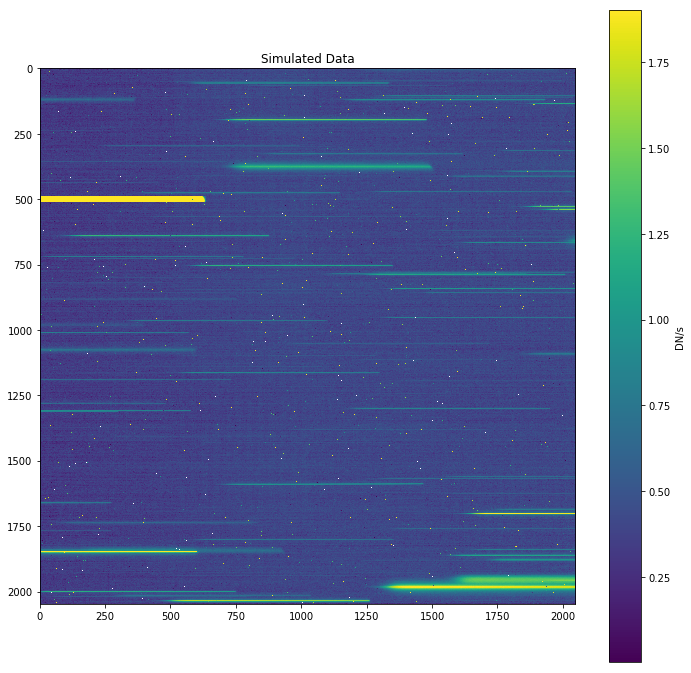

In [17]:
# Show on a log scale, to bring out the presence of the dark current
# Noise in the CDS image makes for a lot of pixels with values < 0,
# which makes this kind of an ugly image. Add an offset so that
# everything is positive and the noise is visible
offset = 2.
plt.figure(figsize=(12,12))
plt.imshow(np.log10(diffdata+offset),clim=(0.001,np.log10(80)))
plt.title('Simulated Data')
plt.colorbar().set_label('DN/s')

---
<a id='run_steps_together'></a>
# Running simulation steps together

## For convenience, combine the steps above into a single function.

In [18]:
from mirage import wfss_simulator

Currently, the wfss_simulator function below only works for the simplest WFSS case. Several imaging mode seed images are created. These are fed into the disperser to produce the dispersed seed image. This is then combined with the dark current observation to create the simulated dispersed data. 

In [ ]:
# First, run all steps of the imaging simulator for yaml file #1
yfiles = [yamlfile1,yamlfile2,yamlfile3,yamlfile4]
crossing_filter = 'F444W'
disp_dir = 'R'
module = 'A'
dark_prep_output = 'wfss_example_data/V42424024002P000000000112o_B5_F250M_seed_uncal_linear_dark_prep_object.fits'


m = wfss_simulator.WFSSSim()
m.paramfiles = yfiles
m.crossing_filter = crossing_filter
m.direction = disp_dir
m.module = module
# optionally, to skip the dark_prep step if you already 
# have the appropriate dark current file that has been
# output by a prior run of dark_prep, you can choose to
# skip the dark_prep step using the line below

#m.override_dark = dark_prep_output

m.create()

---
<a id='mult_sims'></a>
# Running Multiple Simulations

### Each yaml file will simulate an exposure for a single pointing using a single detector.

To simulate an exposure using multiple detectors, you must have multiple yaml files. This can be performed either in series or in parallel:

### In Series
```python
paramlist = [[yaml_a5_filt1_pointing1,yaml_a5_filt2_pointing1,yaml_a5_filt3_pointing1],
             [yaml_a5_filt1_pointing2,yaml_a5_filt2_pointing2,yaml_a5_filt3_pointing2],
             [yaml_b5_filt1_pointing3,yaml_b5_filt2_pointing3,yaml_b5_filt3_pointing3],
             [yaml_b5_filt1_pointing4,yaml_b5_filt2_pointing4,yaml_b5_filt3_pointing4]]
cr_filts = ['F444W','F444W','F356W','F410M']
dirs = ['R','R','C','C']
mods = ['A','A','B','B']

def many_wfss(paramfiles,filts,directions,modules):
    '''Function to run many simulations in series
    '''
    for files, filt, direct, mod in zip(paramlist, cr_filts, dirs, mods):
        m = wfss_simulator.WFSSSim()
        m.paramfiles = files
        m.crossing_filter = filt
        m.direction = direct
        m.module = mod
        m.create()
```

### In Parallel

Since each `yaml` simulations does not depend on the others, we can parallelize the process to speed things up:
```python
from multiprocessing import Pool

n_procs = 5 # number of cores available

with Pool(n_procs) as pool:
    pool.map(make_sim, paramlist)
```

---
<a id='make_yaml'></a>
# Generating input yaml files

For convenience, observing programs with multiple pointings 
and detectors can be simulated starting with the program's 
APT file. The xml and pointings files must be exported from 
APT, and are then used as input into a tool that will
generate a series of yaml input files.

In [20]:
from mirage.apt import apt_inputs
from mirage.yaml import yaml_generator

In [ ]:
# THIS STILL NEEDS TO BE TESTED FOR THE WFSS CASE. IMAGING CASE WORKS

# # Create a series of data simluator input yaml files
# # from APT files
# yam = yaml_generator.SimInput()
# yam.input_xml = 'example_imaging_program.xml'
# yam.pointing_file = 'example_imaging_program.pointing'
# yam.siaf = '/ifs/jwst/wit/witserv/data4/nrc/hilbert/simulated_data/NIRCam_SIAF_2017-03-28.csv'
# yam.output_dir = './'
# yam.simdata_output_dir = './'
# yam.observation_table = 'observation_list.yaml'
# yam.use_JWST_pipeline = True
# yam.use_linearized_darks = False
# yam.datatype = 'linear'
# yam.reffile_setup()
# yam.create_inputs()

In [ ]:
# yfiles = glob(os.path.join(yam.output_dir,'V*yaml'))

---
<a id='yaml_example'></a>
# Example yaml input file

Entries listed as 'config' have default files that are present in the 
config directory of the repository. The scripts are set up to 
automatically find and use these files. The user can replace 'config'
with a filename if they wish to override the default.

In general, if 'None' is placed in a field, then the step that uses
that particular file will be skipped.

Note that the linearized_darkfile entry overrides the dark entry, unless
linearized_darkfile is set to None, in which case the dark entry will be
used.

Use of a valid readout pattern in the readpatt entry will cause the 
simulator to look up the values of nframe and nskip and ignore the 
values given in the yaml file.

```yaml
Inst:
  instrument: NIRCam          #Instrument name
  mode: imaging               #Observation mode (e.g. imaging, WFSS, moving_target)
  use_JWST_pipeline: False   #Use pipeline in data transformations

Readout:
  readpatt: RAPID  #Readout pattern (RAPID, BRIGHT2, etc) overrides nframe,nskip unless it is not recognized
  ngroup: 3        #Number of groups in integration
  nint: 1          #Number of integrations per exposure
  array_name: NRCB5_FULL    #Name of array (FULL, SUB160, SUB64P, etc)
  filter: F250M       #Filter of simulated data (F090W, F322W2, etc)
  pupil: CLEAR        #Pupil element for simulated data (CLEAR, GRISMC, etc)

Reffiles:                                 #Set to None or leave blank if you wish to skip that step
  dark: None   #Dark current integration used as the base
  linearized_darkfile: $MIRAGE_DATA/nircam/darks/linearized/B5/Linearized_Dark_and_SBRefpix_NRCNRCBLONG-DARK-60090141241_1_490_SE_2016-01-09T02h46m50_uncal.fits # Linearized dark ramp to use as input. Supercedes dark above
  badpixmask: $MIRAGE_DATA/nircam/reference_files/badpix/NRCB5_17161_BPM_ISIMCV3_2016-01-21_ssbspmask_DMSorient.fits # If linearized dark is used, populate output DQ extensions using this file
  superbias: $MIRAGE_DATA/nircam/reference_files/superbias/NRCB5_superbias_from_list_of_biasfiles.list.fits  #Superbias file. Set to None or leave blank if not using
  linearity: $MIRAGE_DATA/nircam/reference_files/linearity/NRCBLONG_17161_LinearityCoeff_ADU0_2016-05-22_ssblinearity_v2_DMSorient.fits    #linearity correction coefficients
  saturation: $MIRAGE_DATA/nircam/reference_files/saturation/NRCB5_17161_WellDepthADU_2016-03-10_ssbsaturation_wfact_DMSorient.fits    #well depth reference files
  gain: $MIRAGE_DATA/nircam/reference_files/gain/NRCB5_17161_Gain_ISIMCV3_2016-02-25_ssbgain_DMSorient.fits #Gain map
  pixelflat: None 
  illumflat: None                               #Illumination flat field file
  astrometric: $MIRAGE_DATA/nircam/reference_files/distortion/NRCB5_FULL_distortion.asdf  #Astrometric distortion file (asdf)
  distortion_coeffs: $MIRAGE_DATA/nircam/reference_files/SIAF/NIRCam_SIAF_2017-03-28.csv        #CSV file containing distortion coefficients
  ipc: $MIRAGE_DATA/nircam/reference_files/ipc/NRCB5_17161_IPCDeconvolutionKernel_2016-03-18_ssbipc_DMSorient.fits #File containing IPC kernel to apply
  invertIPC: True       #Invert the IPC kernel before the convolution. True or False. Use True if the kernel is designed for the removal of IPC effects, like the JWST reference files are.
  occult: None                                    #Occulting spots correction image
  pixelAreaMap: /ifs/jwst/wit/nircam/nircam_simulator_data/reference_files/pam/NIRCam_B5_PAM_imaging.fits #Pixel area map for the detector. Used to introduce distortion into the output ramp.
  subarray_defs:   config   #File that contains a list of all possible subarray names and coordinates
  readpattdefs:    config   #File that contains a list of all possible readout pattern names and associated NFRAME/NSKIP values
  crosstalk:       config   #File containing crosstalk coefficients
  filtpupilcombo:  config   #File that lists the filter wheel element / pupil wheel element combinations. Used only in writing output file
  flux_cal:        config   #File that lists flux conversion factor and pivot wavelength for each filter. Only used when making direct image outputs to be fed into the grism disperser code.
  
nonlin:
  limit: 60000.0                           #Upper singal limit to which nonlinearity is applied (ADU)
  accuracy: 0.000001                        #Non-linearity accuracy threshold
  maxiter: 10                              #Maximum number of iterations to use when applying non-linearity
  robberto:  False                         #Use Massimo Robberto type non-linearity coefficients

cosmicRay:
  path: $MIRAGE_DATA/nircam/cosmic_ray_library/         #Path to CR library
  library: SUNMIN    #Type of cosmic rayenvironment (SUNMAX, SUNMIN, FLARE)
  scale: 1.5     #Cosmic ray scaling factor
  suffix: IPC_NIRCam_B5    #Suffix of library file names
  seed: 2956411739      #Seed for random number generator

simSignals:
  pointsource: my_ptsrc.cat #File containing a list of point sources to add (x,y locations and magnitudes)
  psfpath: $MIRAGE_DATA/nircam/psf_data/        #Path to PSF library
  psfbasename: nircam                        #Basename of the files in the psf library
  psfpixfrac: 0.1                           #Fraction of a pixel between entries in PSF library (e.g. 0.1 = files for PSF centered at 0.1 pixel intervals within pixel)
  psfwfe: 123                               #PSF WFE value (0,115,123,132,136,150,155)
  psfwfegroup: 0                             #WFE realization group (0 to 9)
  galaxyListFile: my_galaxies.cat
  extended: None          #Extended emission count rate image file name
  extendedscale: 1.0         #Scaling factor for extended emission image
  extendedCenter: 1024,1024  #x,y pixel location at which to place the extended image if it is smaller than the output array size
  PSFConvolveExtended: True #Convolve the extended image with the PSF before adding to the output image (True or False)
  movingTargetList: None   #Name of file containing a list of point source moving targets (e.g. KBOs, asteroids) to add.
  movingTargetSersic: None  #ascii file containing a list of 2D sersic profiles to have moving through the field
  movingTargetExtended: None      #ascii file containing a list of stamp images to add as moving targets (planets, moons, etc)
  movingTargetConvolveExtended: True       #convolve the extended moving targets with PSF before adding.
  movingTargetToTrack: None #File containing a single moving target which JWST will track during observation (e.g. a planet, moon, KBO, asteroid)	This file will only be used if mode is set to "moving_target" 
  zodiacal:  None                          #Zodiacal light count rate image file 
  zodiscale:  1.0                            #Zodi scaling factor
  scattered:  None                          #Scattered light count rate image file
  scatteredscale: 1.0                        #Scattered light scaling factor
  bkgdrate: 0.0                         #Constant background count rate (electrons/sec/pixel)
  poissonseed: 2012872553                  #Random number generator seed for Poisson simulation)
  photonyield: True                         #Apply photon yield in simulation
  pymethod: True                            #Use double Poisson simulation for photon yield

Telescope:
  ra: 53.1                     #RA of simulated pointing
  dec: -27.8                   #Dec of simulated pointing
  rotation: 0.0                #y axis rotation (degrees E of N)
  tracking: sidereal           #sidereal or non-sidereal

newRamp:
  dq_configfile: config          #config file used by JWST pipeline
  sat_configfile: config         #config file used by JWST pipeline
  superbias_configfile: config   #config file used by JWST pipeline
  refpix_configfile: config      #config file used by JWST pipeline 
  linear_configfile: config      #config file used by JWST pipeline

Output:
  file: V42424024002P000000000112o_B5_F250M_uncal.fits   #Output filename
  directory: ./   # Directory in which to place output files
  datatype: linear,raw # Type of data to save. 'linear' for linearized ramp. 'raw' for raw ramp. 'linear,raw' for both
  format: DMS          #Output file format Options: DMS, SSR(not yet implemented)
  save_intermediates: False   #Save intermediate products separately (point source image, etc)
  grism_source_image: False   # Create an image to be dispersed?
  unsigned: True   #Output unsigned integers? (0-65535 if true. -32768 to 32768 if false)
  dmsOrient: True    #Output in DMS orientation (vs. fitswriter orientation).
  program_number: 42424    #Program Number
  title: Supernovae and Black Holes Near Hyperspatial Bypasses   #Program title
  PI_Name: Doug Adams  #Proposal PI Name
  Proposal_category: GO  #Proposal category
  Science_category: Cosmology  #Science category
  observation_number: '002'    #Observation Number
  observation_label: Obs2    #User-generated observation Label
  visit_number: '024'    #Visit Number
  visit_group: '01'    #Visit Group
  visit_id: '42424024002'    #Visit ID
  sequence_id: '2'    #Sequence ID
  activity_id: '2o'    #Activity ID. Increment with each exposure.
  exposure_number: '00001'    #Exposure Number
  obs_id: 'V42424024002P000000000112o'   #Observation ID number
  date_obs: '2019-10-15'  #Date of observation
  time_obs: '06:29:11.852'  #Time of observation
  obs_template: 'NIRCam Imaging'  #Observation template
  primary_dither_type: NONE  #Primary dither pattern name
  total_primary_dither_positions: 1  #Total number of primary dither positions
  primary_dither_position: 1  #Primary dither position number
  subpix_dither_type: 2-POINT-MEDIUM-WITH-NIRISS  #Subpixel dither pattern name
  total_subpix_dither_positions: 2  #Total number of subpixel dither positions
  subpix_dither_position: 2  #Subpixel dither position number
  xoffset: 344.284  #Dither pointing offset in x (arcsec)
  yoffset: 466.768  #Dither pointing offset in y (arcsec)
```